In [2]:
import duckdb
con = duckdb.connect()

Create a sample table

In [3]:
# Create a sample table
sql = """
CREATE TABLE sample_data (
    id INTEGER,
    value INTEGER
);
"""
con.execute(sql)

Insert sample data

In [4]:
sql = """
INSERT INTO sample_data VALUES (1, 10), (2, 15), (3, 20), (4, 25), (5, 30);
"""
con.execute(sql)

Calculate moving average (3-period moving average)
[Window Function#framing](https://duckdb.org/docs/sql/functions/window_functions#framing)

In [7]:
sql = """
SELECT id, 
       value, 
       AVG(value) OVER (ORDER BY id ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_average
FROM sample_data
"""
con.sql(sql)

┌───────┬───────┬────────────────┐
│  id   │ value │ moving_average │
│ int32 │ int32 │     double     │
├───────┼───────┼────────────────┤
│     1 │    10 │           10.0 │
│     2 │    15 │           12.5 │
│     3 │    20 │           15.0 │
│     4 │    25 │           20.0 │
│     5 │    30 │           25.0 │
└───────┴───────┴────────────────┘

In [14]:
sql2 = f'COPY ({sql}) TO sample_mv.csv (HEADER, DELIMITER ",")'
print(sql2)
con.execute(sql2)

COPY (
SELECT id, 
       value, 
       AVG(value) OVER (ORDER BY id ROWS BETWEEN 2 PRECEDING AND CURRENT ROW) AS moving_average
FROM sample_data
) TO sample_mv.csv (HEADER, DELIMITER ",")


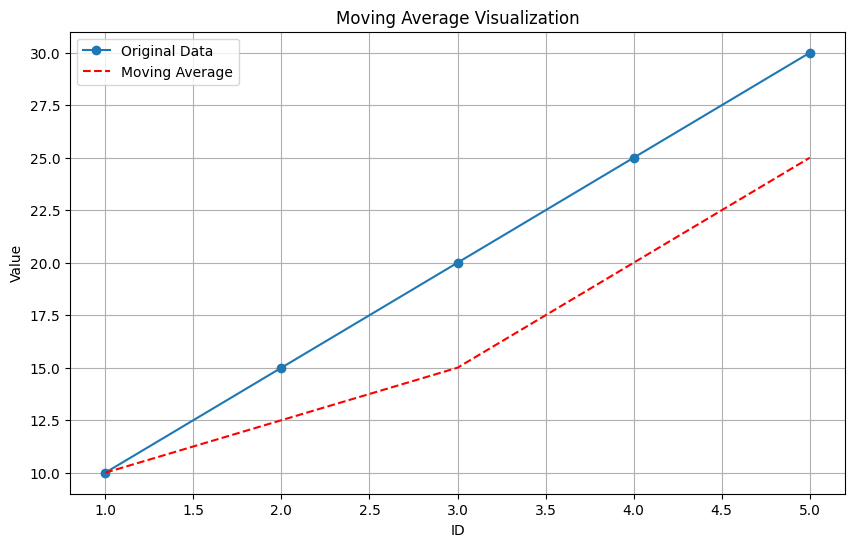

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV into a pandas DataFrame
data = pd.read_csv('sample_mv.csv')

# Create a line plot with the original data and the moving average
plt.figure(figsize=(10, 6))
plt.plot(data['id'], data['value'], label='Original Data', marker='o')
plt.plot(data['id'], data['moving_average'], label='Moving Average', linestyle='--', color='red')
plt.xlabel('ID')
plt.ylabel('Value')
plt.title('Moving Average Visualization')
plt.legend()
plt.grid(True)
plt.show()

Window and Range function

In [19]:
sql = """
SELECT id, value, 
       QUANTILE_CONT(value, [0.5, 0.8]) OVER seven AS median_value
FROM sample_data
WINDOW seven AS (ORDER BY value ASC)
ORDER BY 1
"""
con.sql(sql)

┌───────┬───────┬──────────────┐
│  id   │ value │ median_value │
│ int32 │ int32 │   double[]   │
├───────┼───────┼──────────────┤
│     1 │    10 │ [10.0, 10.0] │
│     2 │    15 │ [12.5, 14.0] │
│     3 │    20 │ [15.0, 18.0] │
│     4 │    25 │ [17.5, 22.0] │
│     5 │    30 │ [20.0, 26.0] │
└───────┴───────┴──────────────┘

In [20]:
sql = """
SELECT id, value, 
       QUANTILE_DISC(value, [0.5, 0.8]) OVER seven AS median_value
FROM sample_data
WINDOW seven AS (ORDER BY value ASC)
ORDER BY 1
"""
con.sql(sql)

┌───────┬───────┬──────────────┐
│  id   │ value │ median_value │
│ int32 │ int32 │   int32[]    │
├───────┼───────┼──────────────┤
│     1 │    10 │ [10, 10]     │
│     2 │    15 │ [10, 15]     │
│     3 │    20 │ [15, 20]     │
│     4 │    25 │ [15, 25]     │
│     5 │    30 │ [20, 25]     │
└───────┴───────┴──────────────┘

EMA, calculate the exponential moving average (EMA) using window functions and the EXP function to calculate the exponential weight.

alpha is the smoothing factor, calculated as 2 / (N + 1) where N is typically the number of periods for which you want to calculate the EMA.
The recursive CTE ema_calc calculates the EMA recursively based on the previous EMA value and the current data point.

### Short-Term EMA:

For short-term analysis and responsiveness to recent changes, a smaller N is typically used.
Common values for short-term EMAs might include N = 5 or N = 10, resulting in smoothing factors of approximately 0.2857 and 0.1667, respectively.

### Medium-Term EMA:

For a balance between responsiveness and smoothing, medium-term EMAs are often employed.
Values such as N = 12, N = 14, or N = 20 are commonly used, corresponding to smoothing factors around 0.1538, 0.1429, and 0.0909, respectively.

### Long-Term EMA:

Long-term EMAs are used to capture longer trends and are less sensitive to short-term fluctuations.
Values like N = 50, N = 100, or N = 200 are typical for long-term EMAs, resulting in smoothing factors of around 0.0385, 0.0196, and 0.0099, respectively.

In [21]:
sql = """
WITH RECURSIVE ema_calc AS (
    SELECT 
        id,
        value,
        2.0 / (14.0 + 1) AS alpha, -- Assuming a smoothing factor of 14
        value AS ema
    FROM sample_data
    WHERE id = 1

    UNION ALL

    SELECT 
        sd.id,
        sd.value,
        alpha,
        (sd.value * alpha) + (1 - alpha) * ema AS ema
    FROM sample_data sd
    JOIN ema_calc ec ON sd.id = ec.id + 1
)

SELECT id, value, ema
FROM ema_calc;
"""
con.sql(sql)

┌───────┬───────┬───────┐
│  id   │ value │  ema  │
│ int32 │ int32 │ int32 │
├───────┼───────┼───────┤
│     1 │    10 │    10 │
│     2 │    15 │    11 │
│     3 │    20 │    12 │
│     4 │    25 │    14 │
│     5 │    30 │    16 │
└───────┴───────┴───────┘